# ICLR Plots

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [13]:
from utils import make_test_set_esnli, make_test_set_mnli, make_test_set_cose

NUM_EXPL = 100

dataset_esnli = make_test_set_esnli(size=NUM_EXPL) # 9830 is dev size esnli (originally 9842 but 12 instance are wrongly annotated)
dataset_mnli = make_test_set_mnli(size=NUM_EXPL) # 9815 is dev size mnli


Found cached dataset parquet (/Users/henningheyen/.cache/huggingface/datasets/parquet/multi_nli-ef06e62ad966d552/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
# Importing results calculated on Colab servers
import json


# Read the file
with open('results/json/explainability_results_mnli.json', 'r') as f:
    explainability_results_mnli = json.load(f)

# Read the file
with open('results/json/explainability_results_esnli.json', 'r') as f:
    explainability_results_esnli = json.load(f)

# Read the file
with open('results/json/explainability_results_cose_wo_large.json', 'r') as f:
    explainability_results_cose_wo_large = json.load(f)

# Read the file
with open('results/json/explainability_results_cose_large.json', 'r') as f:
    explainability_results_cose_large = json.load(f)

with open('results/json/predictions_for_explanations.json', 'r') as f:
    predictions_for_explanations = json.load(f)


In [15]:
# Merging cose results
explainability_results_cose = explainability_results_cose_wo_large
explainability_results_cose['cose']['large'] = explainability_results_cose_large['cose']['large']


In [16]:
def print_key_tree(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key) + ": " + str(type(value)))
        if isinstance(value, dict):
            print_key_tree(value, indent + 1)
        elif isinstance(value, list):
            if all(isinstance(i, dict) for i in value):
                for sub_dict in value:
                    print_key_tree(sub_dict, indent + 1)

In [41]:
print_key_tree(explainability_results_esnli['esnli'])

xsmall: <class 'dict'>
  explanations_as_list: <class 'list'>
  faithfulness: <class 'dict'>
    comprehensiveness: <class 'list'>
    macro_comprehensiveness: <class 'float'>
    sufficiency: <class 'list'>
    macro_sufficiency: <class 'float'>
    comp_contradiction: <class 'list'>
    comp_entailment: <class 'list'>
    comp_neutral: <class 'list'>
    suff_contradiction: <class 'list'>
    suff_entailment: <class 'list'>
    suff_neutral: <class 'list'>
    sem_comp: <class 'numpy.float64'>
    sem_suff: <class 'numpy.float64'>
  plausibility: <class 'dict'>
    iou: <class 'list'>
    macro_iou: <class 'float'>
    tokenf1: <class 'list'>
    macro_tokenf1: <class 'float'>
    sem_iou: <class 'numpy.float64'>
    sem_tokenf1: <class 'numpy.float64'>
  correct_idx: <class 'list'>
small: <class 'dict'>
  explanations_as_list: <class 'list'>
  faithfulness: <class 'dict'>
    comprehensiveness: <class 'list'>
    macro_comprehensiveness: <class 'float'>
    sufficiency: <class 'list

In [18]:
# all in one dictionary:
explainability_results = {}
explainability_results['mnli'] = explainability_results_mnli['mnli']
explainability_results['esnli'] = explainability_results_esnli['esnli']
explainability_results['cose'] = explainability_results_cose['cose']



In [19]:
model_names = ['xsmall', 'small', 'base', 'large']
model_sizes = ['xsmall (22m)', 'small (44m)', 'base (86m) ', 'large (304m)']
datasets = ['esnli', 'mnli', 'cose']
dataset_labels = ['e-SNLI', 'MNLI', 'CoS-e']

In [20]:
# Indices by labels
contradiction_idx_esnli = [i for i in range(NUM_EXPL) if dataset_esnli['test_labels_text'][i] == 'contradiction']
entailment_idx_esnli = [i for i in range(NUM_EXPL) if dataset_esnli['test_labels_text'][i] == 'entailment']
neutral_idx_esnli = [i for i in range(NUM_EXPL) if dataset_esnli['test_labels_text'][i] == 'neutral']

contradiction_idx_mnli = [i for i in range(NUM_EXPL) if dataset_mnli['test_labels_text'][i] == 'contradiction']
entailment_idx_mnli = [i for i in range(NUM_EXPL) if dataset_mnli['test_labels_text'][i] == 'entailment']
neutral_idx_mnli = [i for i in range(NUM_EXPL) if dataset_mnli['test_labels_text'][i] == 'neutral']

explainability_results['mnli']['indices'] = {'contradiction_idx': contradiction_idx_mnli, 'entailment_idx': entailment_idx_mnli, 'neutral_idx': neutral_idx_mnli}
explainability_results['esnli']['indices'] = {'contradiction_idx': contradiction_idx_esnli, 'entailment_idx': entailment_idx_esnli, 'neutral_idx': neutral_idx_esnli}

In [21]:
# Indices by correct predicition

for dataset in datasets:
    for model_name in model_names:
        explainability_results[dataset][model_name]['correct_idx'] = [True if predictions_for_explanations[dataset]['true'][i] == predictions_for_explanations[dataset][model_name]['pred'][i] else False for i in range(NUM_EXPL)]

In [22]:
import numpy as np

def get_sem(list): # standard error of the mean 
    std_dev = np.std(list)
    n = len(list)
    return std_dev / np.sqrt(n)

In [23]:
# splitting by label
for dataset in ['mnli', 'esnli']:
    for model_name in model_names:

        comp = explainability_results[dataset][model_name]['faithfulness']['comprehensiveness']
        explainability_results[dataset][model_name]['faithfulness']['comp_contradiction'] = [comp[i] for i in explainability_results[dataset]['indices']['contradiction_idx']]
        explainability_results[dataset][model_name]['faithfulness']['comp_entailment'] = [comp[i] for i in explainability_results[dataset]['indices']['entailment_idx']]
        explainability_results[dataset][model_name]['faithfulness']['comp_neutral'] = [comp[i] for i in explainability_results[dataset]['indices']['neutral_idx']]

        suff = explainability_results[dataset][model_name]['faithfulness']['sufficiency']
        explainability_results[dataset][model_name]['faithfulness']['suff_contradiction'] = [suff[i] for i in explainability_results[dataset]['indices']['contradiction_idx']]
        explainability_results[dataset][model_name]['faithfulness']['suff_entailment'] = [suff[i] for i in explainability_results[dataset]['indices']['entailment_idx']]
        explainability_results[dataset][model_name]['faithfulness']['suff_neutral'] = [suff[i] for i in explainability_results[dataset]['indices']['neutral_idx']]


In [24]:
# splitting by prediction
for dataset in datasets:
    for model_name in model_names:
        explainability_results[dataset][model_name]['faithfulness']['sem_comp'] = get_sem(explainability_results[dataset][model_name]['faithfulness']['comprehensiveness'])
        explainability_results[dataset][model_name]['faithfulness']['sem_suff'] = get_sem(explainability_results[dataset][model_name]['faithfulness']['sufficiency'])
        if dataset != 'mnli':
            explainability_results[dataset][model_name]['plausibility']['sem_iou'] = get_sem(explainability_results[dataset][model_name]['plausibility']['iou'])
            explainability_results[dataset][model_name]['plausibility']['sem_tokenf1'] = get_sem(explainability_results[dataset][model_name]['plausibility']['tokenf1'])

# Performance

In [25]:
# Importing results calculated on Colab servers
import json

# Read the file
with open('results/json/results.json', 'r') as f:
    results = json.load(f)

# Read the file
with open('results/json/confidence_intervals.json', 'r') as f:
    confidence_intervals = json.load(f)


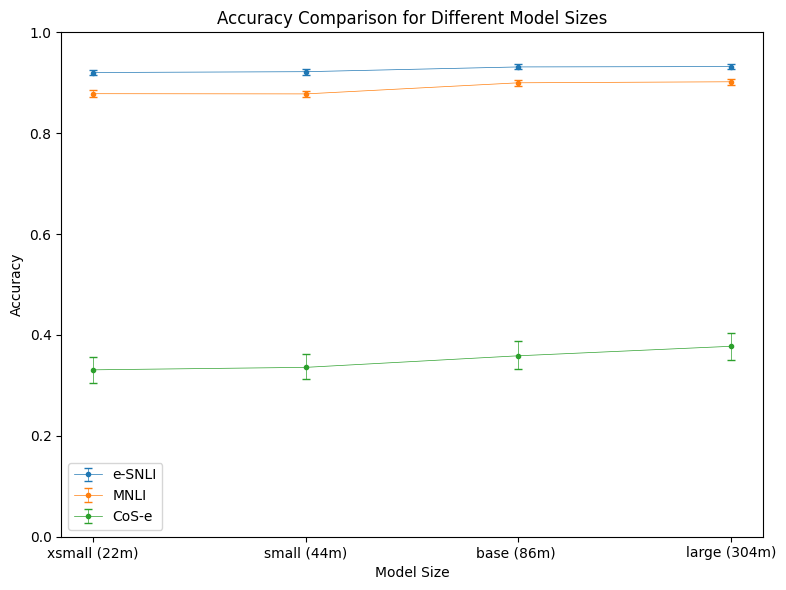

In [26]:
import matplotlib.pyplot as plt

model_names = ['xsmall', 'small', 'base', 'large']
datasets = ['esnli', 'mnli', 'cose']
dataset_labels = ['e-SNLI', 'MNLI', 'CoS-e']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8,6))

# Define your datasets and model_names if not already defined
datasets = ['esnli', 'mnli', 'cose']
dataset_labels = ['e-SNLI', 'MNLI', 'CoS-e']
model_sizes = ['xsmall (22m)', 'small (44m)', 'base (86m) ', 'large (304m)']

# Iterate through each dataset
for i, dataset in enumerate(datasets):
    dataset_results = results[dataset]
    accuracies = [dataset_results[model]['accuracy'] for model in model_names]
    
    # Extract confidence intervals for the dataset and models
    conf_intervals = [confidence_intervals[dataset][model]['accuracy'] for model in model_names]
    
    # Separate the lower and upper bounds of the confidence intervals
    lower_bounds = [acc - lower for acc, (lower, upper) in zip(accuracies, conf_intervals)]
    upper_bounds = [upper - acc for acc, (lower, upper) in zip(accuracies, conf_intervals)]

    # Plot with error bars
    ax.errorbar(model_sizes, accuracies, yerr=[lower_bounds, upper_bounds], 
                marker='o',capsize=3 , markersize=3, label=dataset_labels[i], linewidth=0.5)

ax.set_title("Accuracy Comparison for Different Model Sizes")
ax.set_xlabel("Model Size")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)  # Set y-axis limits to 0 to 1
ax.legend()

plt.tight_layout()
plt.show()

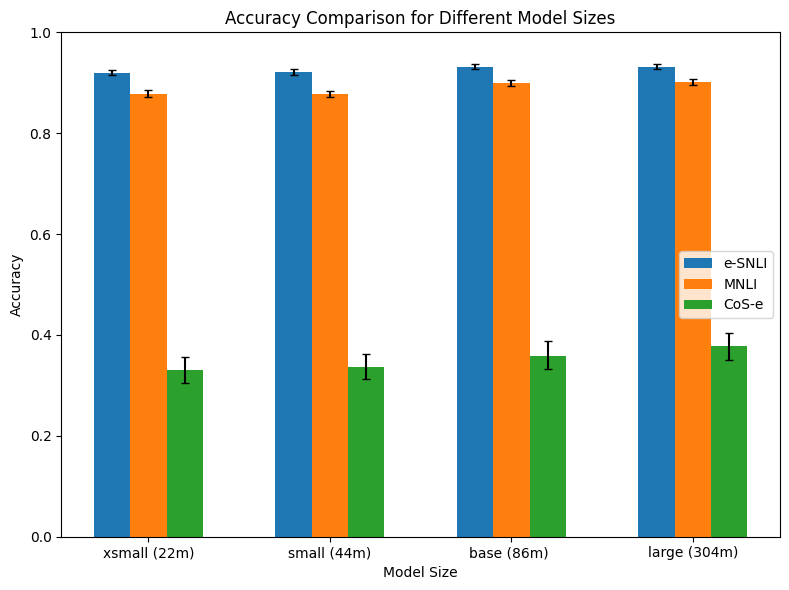

In [77]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['xsmall', 'small', 'base', 'large']
datasets = ['esnli', 'mnli', 'cose']
dataset_labels = ['e-SNLI', 'MNLI', 'CoS-e']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Define your datasets and model_names if not already defined
datasets = ['esnli', 'mnli', 'cose']
dataset_labels = ['e-SNLI', 'MNLI', 'CoS-e']
model_sizes = ['xsmall (22m)', 'small (44m)', 'base (86m) ', 'large (304m)']

num_models = len(model_names)
num_datasets = len(datasets)
bar_width = 0.2  # Width of each bar

# Iterate through each dataset
for i, dataset in enumerate(datasets):
    dataset_results = results[dataset]
    accuracies = [dataset_results[model]['accuracy'] for model in model_names]

    # Extract confidence intervals for the dataset and models
    conf_intervals = [confidence_intervals[dataset][model]['accuracy'] for model in model_names]
    
    # Separate the lower and upper bounds of the confidence intervals
    errors = [[acc - lower, upper - acc] for acc, (lower, upper) in zip(accuracies, conf_intervals)]
    errors = np.array(errors).T  # Transpose to align with bar plot format

    # Calculate positions for each bar
    positions = np.arange(num_models) + i * (bar_width)

    # Plot with error bars
    ax.bar(positions, accuracies, bar_width, yerr=errors, capsize=3, label=dataset_labels[i])

# Set axis labels and title
ax.set_title("Accuracy Comparison for Different Model Sizes")
ax.set_xlabel("Model Size")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)  # Set y-axis limits to 0 to 1

# Set x-ticks to be in the middle of each group of bars
group_middle = np.arange(num_models) + (num_datasets - 1) * (bar_width) / 2
ax.set_xticks(group_middle)
ax.set_xticklabels(model_sizes)

ax.legend()

plt.tight_layout()
plt.show()


# Overall Comprehensiveness

/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_42281/3373613418.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'{label}', capsize=3, marker='o', color=color)


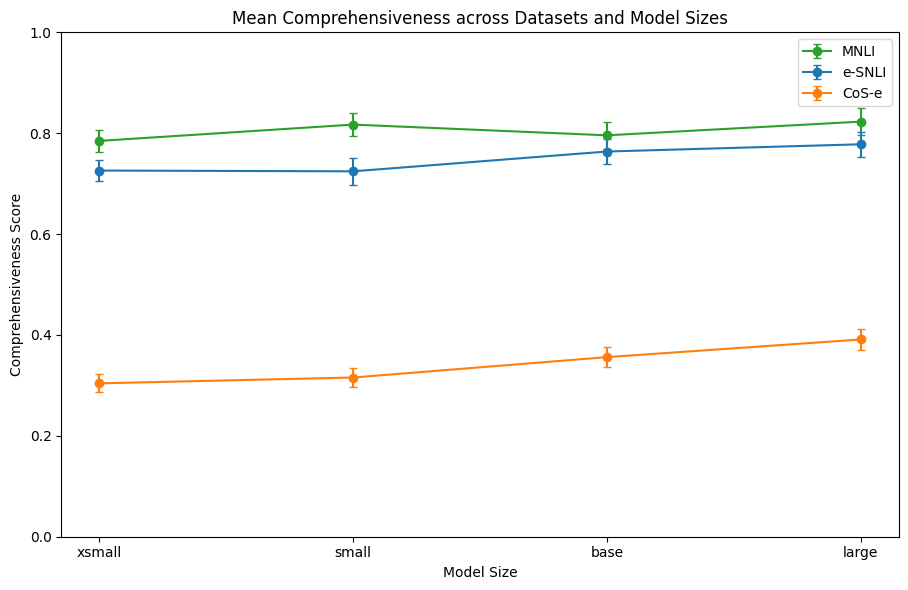

In [79]:
import matplotlib.pyplot as plt

# Create a single figure
plt.figure(figsize=(12, 6))

datasets = ['mnli', 'esnli', 'cose']
dataset_labels = ['MNLI', 'e-SNLI', 'CoS-e']
dataset_colors = ['tab:green', 'tab:blue', 'tab:orange']
model_sizes = ['xsmall', 'small', 'base', 'large']

# Plotting macro_comprehensiveness with SEM
for dataset, label, color in zip(datasets, dataset_labels, dataset_colors):
    y_values = [explainability_results[dataset][model_name]['faithfulness']['macro_comprehensiveness'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['faithfulness']['sem_comp'] for model_name in model_sizes]
    plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'{label}', capsize=3, marker='o', color=color)

plt.ylim(0, 1)
plt.xlabel('Model Size')
plt.ylabel('Comprehensiveness Score')
plt.title('Mean Comprehensiveness across Datasets and Model Sizes')
plt.xticks(ticks=np.arange(len(model_names)), labels=model_names)  # Set x-tick labels to model names

# Place the legend outside the plot area
plt.legend(loc='best', bbox_to_anchor=(1, 1))

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()


# Overall IOU

/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_42281/729520620.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'{label}', capsize=3, marker='o', color=colors[dataset])


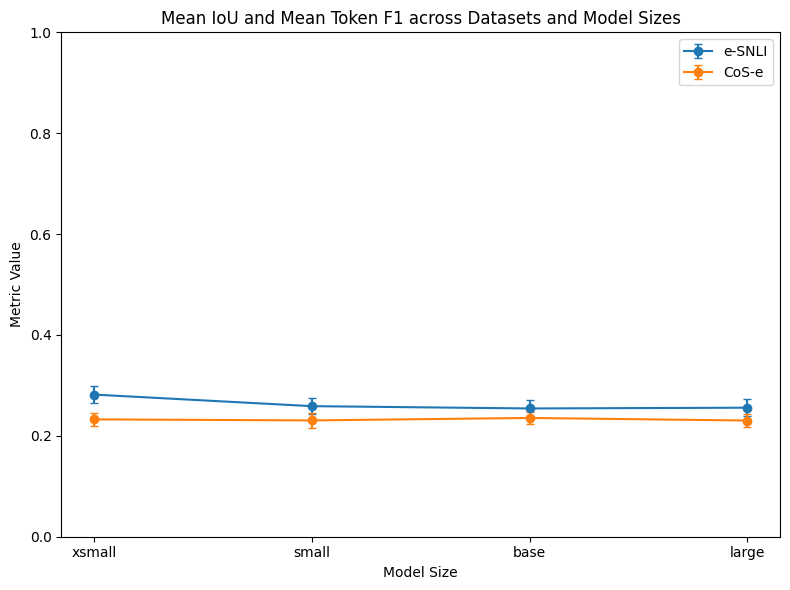

In [80]:
import matplotlib.pyplot as plt

# Create a single figure
plt.figure(figsize=(8, 6))

datasets = ['esnli', 'cose']
dataset_labels = ['e-SNLI', 'CoS-e']
model_sizes = ['xsmall', 'small', 'base', 'large']
colors = {'esnli': 'tab:blue', 'cose': 'tab:orange'}

# Plotting macro_iou with SEM
for dataset, label in zip(datasets, dataset_labels):
    y_values = [explainability_results[dataset][model_name]['plausibility']['macro_iou'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['plausibility']['sem_iou'] for model_name in model_sizes]
    plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'{label}', capsize=3, marker='o', color=colors[dataset])

plt.ylim(0, 1)
plt.xlabel('Model Size')
plt.ylabel('Metric Value')
plt.title('Mean IoU and Mean Token F1 across Datasets and Model Sizes')
plt.xticks(ticks=np.arange(len(model_names)), labels=model_names)  # Set x-tick labels to model names
plt.legend()

plt.tight_layout()
plt.show()


/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_42281/279764325.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'Comprehensiveness - {label}', capsize=3, marker='o', linestyle='-', color=color)
/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_42281/279764325.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'Comprehensiveness - {label}', capsize=3, marker='o', linestyle='-', color=color)
/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_42281/279764325.py:25: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='

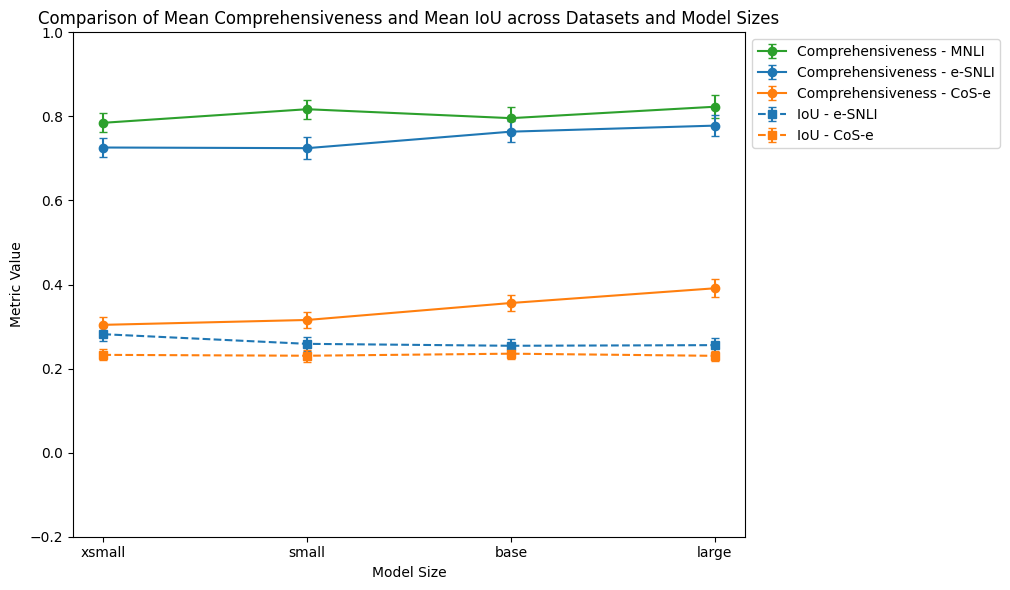

In [47]:
import matplotlib.pyplot as plt

# Data setup (assuming 'explainability_results' is already defined)
datasets = ['mnli', 'esnli', 'cose']
dataset_labels = ['MNLI', 'e-SNLI', 'CoS-e']
dataset_colors = ['tab:green', 'tab:blue', 'tab:orange']
model_sizes = ['xsmall', 'small', 'base', 'large']

# Create a single figure
plt.figure(figsize=(12, 6))

# Plotting macro_comprehensiveness with SEM
for dataset, label, color in zip(datasets, dataset_labels, dataset_colors):
    y_values = [explainability_results[dataset][model_name]['faithfulness']['macro_comprehensiveness'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['faithfulness']['sem_comp'] for model_name in model_sizes]
    plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'Comprehensiveness - {label}', capsize=3, marker='o', linestyle='-', color=color)

# Plotting macro_iou (plausibility) with SEM
plausibility_datasets = ['esnli', 'cose']  # Assuming these are the datasets for plausibility
plausibility_labels = ['e-SNLI', 'CoS-e']
plausibility_colors = {'esnli': 'tab:blue', 'cose': 'tab:orange'}
for dataset, label in zip(plausibility_datasets, plausibility_labels):
    y_values = [explainability_results[dataset][model_name]['plausibility']['macro_iou'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['plausibility']['sem_iou'] for model_name in model_sizes]
    plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='s-', label=f'IoU - {label}', capsize=3, marker='s', linestyle='--', color=plausibility_colors[dataset])

plt.ylim(-0.2, 1)
plt.xlabel('Model Size')
plt.ylabel('Metric Value')
plt.title('Comparison of Mean Comprehensiveness and Mean IoU across Datasets and Model Sizes')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()


/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_42281/3066760154.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'{label}', capsize=3, marker='o', color=color)
/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_42281/3066760154.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axs[1].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'{label}', capsize=3, marker='o', color=colors[dataset])


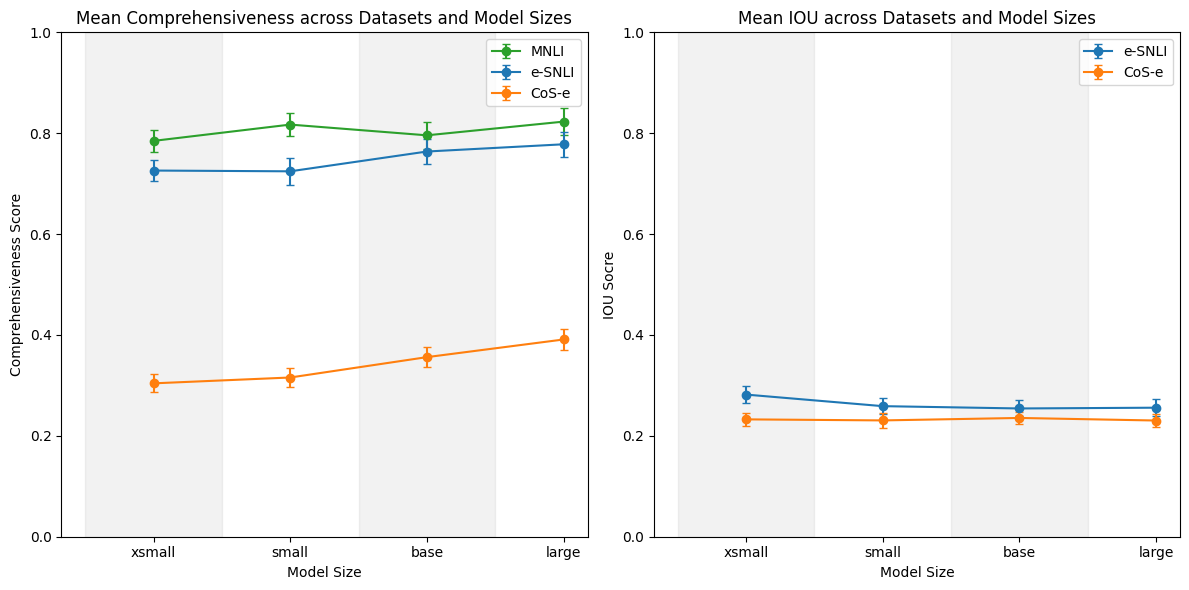

In [83]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

datasets = ['mnli', 'esnli', 'cose']
dataset_labels = ['MNLI', 'e-SNLI', 'CoS-e']
dataset_colors = ['tab:green', 'tab:blue', 'tab:orange']
model_sizes = ['xsmall', 'small', 'base', 'large']

# Assuming 'explainability_results' is a predefined variable with the necessary data

# First subplot for macro_comprehensiveness
for dataset, label, color in zip(datasets, dataset_labels, dataset_colors):
    y_values = [explainability_results[dataset][model_name]['faithfulness']['macro_comprehensiveness'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['faithfulness']['sem_comp'] for model_name in model_sizes]
    axs[0].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'{label}', capsize=3, marker='o', color=color)

axs[0].set_ylim(0, 1)
axs[0].set_xlabel('Model Size')
axs[0].set_ylabel('Comprehensiveness Score')
axs[0].set_title('Mean Comprehensiveness across Datasets and Model Sizes')
axs[0].legend()  # Adding legend to the first subplot

# Second subplot for macro_iou
datasets = ['esnli', 'cose']
dataset_labels = ['e-SNLI', 'CoS-e']
colors = {'esnli': 'tab:blue', 'cose': 'tab:orange'}

for dataset, label in zip(datasets, dataset_labels):
    y_values = [explainability_results[dataset][model_name]['plausibility']['macro_iou'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['plausibility']['sem_iou'] for model_name in model_sizes]
    axs[1].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'{label}', capsize=3, marker='o', color=colors[dataset])

axs[1].set_ylim(0, 1)
axs[1].set_xlabel('Model Size')
axs[1].set_ylabel('IOU Socre')
axs[1].set_title('Mean IOU across Datasets and Model Sizes')
axs[1].legend()  # Adding legend to the second subplot

# Add shadowed background for each category in both subplots
for ax in axs:
    ax.set_xticks(np.arange(len(model_sizes)))
    ax.set_xticklabels(model_sizes)
    for j, model in enumerate(model_sizes):
        if j % 2 == 0:
            ax.axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)

plt.tight_layout()
plt.show()


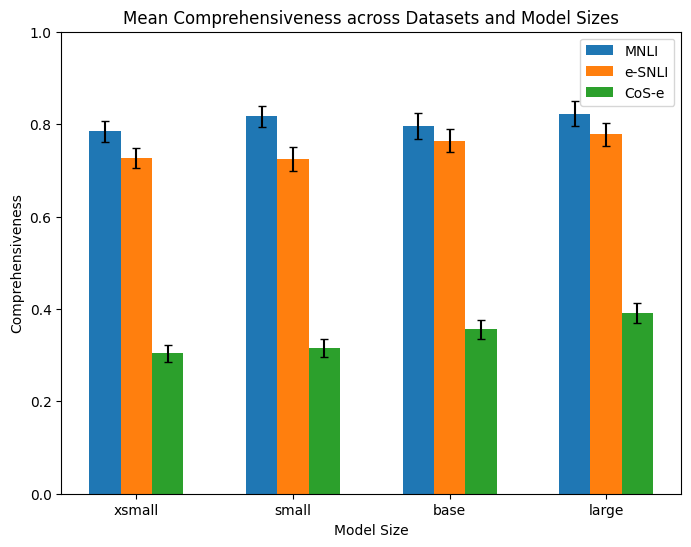

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Data setup (assuming 'explainability_results' is already defined)
datasets = ['mnli', 'esnli', 'cose']
dataset_labels = ['MNLI', 'e-SNLI', 'CoS-e']
model_sizes = ['xsmall', 'small', 'base', 'large']

# Setting up the bar width and positions
bar_width = 0.2
index = np.arange(len(model_sizes))

# Function to calculate bar positions
def get_bar_positions(start_pos, dataset_index, total_datasets):
    return start_pos + bar_width * dataset_index - bar_width * (total_datasets - 1) / 2

# Plot for Comprehensiveness
plt.figure(figsize=(8, 6))
for i, dataset in enumerate(datasets):
    y_values = [explainability_results[dataset][model_size]['faithfulness']['macro_comprehensiveness'] for model_size in model_sizes]
    y_errors = [explainability_results[dataset][model_size]['faithfulness']['sem_comp'] for model_size in model_sizes]
    bar_positions = get_bar_positions(index, i, len(datasets))
    plt.bar(bar_positions, y_values, bar_width, label=f'{dataset_labels[i]}')
    plt.errorbar(bar_positions, y_values, yerr=y_errors, fmt='none', ecolor='black', capsize=3)

plt.xticks(index, model_sizes)
plt.ylim(0, 1)
plt.xlabel('Model Size')
plt.ylabel('Comprehensiveness')
plt.title('Mean Comprehensiveness across Datasets and Model Sizes')
plt.legend()
plt.show()

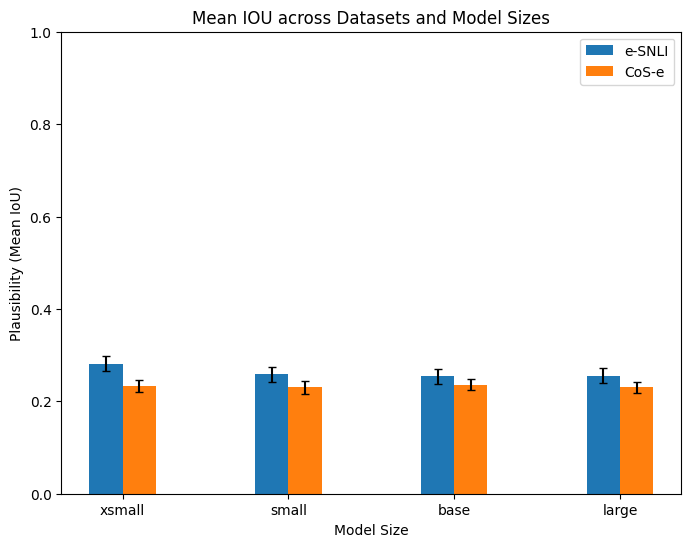

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'explainability_results' is already defined
datasets = ['esnli', 'cose']
dataset_labels = ['e-SNLI', 'CoS-e']
model_sizes = ['xsmall', 'small', 'base', 'large']

# Setting up the bar width and positions
bar_width = 0.2
index = np.arange(len(model_sizes))

# Function to calculate bar positions
def get_bar_positions(start_pos, dataset_index, total_datasets):
    return start_pos + bar_width * dataset_index - bar_width * (total_datasets - 1) / 2

# Plot for Plausibility
plt.figure(figsize=(8, 6))
for i, dataset in enumerate(datasets):
    y_values = [explainability_results[dataset][model_size]['plausibility']['macro_iou'] for model_size in model_sizes]
    y_errors = [explainability_results[dataset][model_size]['plausibility']['sem_iou'] for model_size in model_sizes]
    bar_positions = get_bar_positions(index, i, len(datasets))
    plt.bar(bar_positions, y_values, bar_width, label=f'{dataset_labels[i]}')
    plt.errorbar(bar_positions, y_values, yerr=y_errors, fmt='none', ecolor='black', capsize=3)

plt.xticks(index, model_sizes)
plt.ylim(0, 1)
plt.xlabel('Model Size')
plt.ylabel('Plausibility (Mean IoU)')
plt.title('Mean IOU across Datasets and Model Sizes')
plt.legend()
plt.show()


# Faithfulness by Label

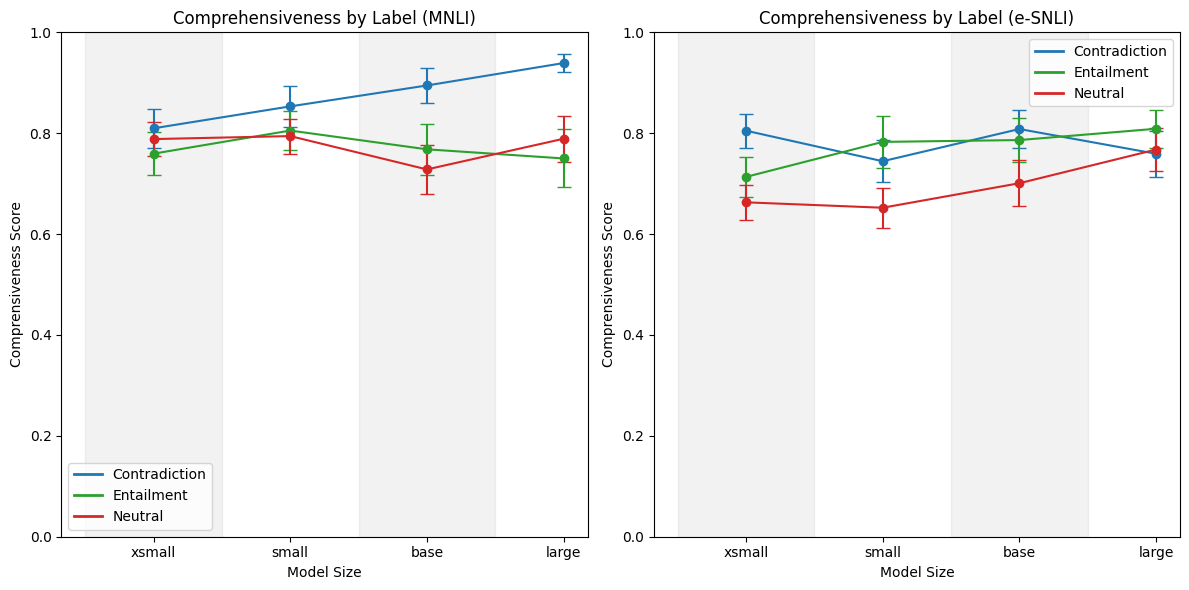

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Function to get SEM
def get_sem(data_list):
    return np.std(data_list) / np.sqrt(len(data_list))

model_names = ['xsmall', 'small', 'base', 'large']
labels = ['contradiction', 'entailment', 'neutral']
dataset_names = ['MNLI', 'e-SNLI']
colors = ['tab:blue', 'tab:green', 'tab:red']

plt.figure(figsize=(12, 6))

for i, dataset in enumerate(['mnli', 'esnli']):
    plt.subplot(1, 2, i+1)
    
    for j, label in enumerate(labels):
        means_comp = []
        sems_comp = []
        
        for model_name in model_names:
            comp_key = f'comp_{label}'
            
            mean_comp = np.mean(explainability_results[dataset][model_name]['faithfulness'][comp_key])
            sem_comp = get_sem(explainability_results[dataset][model_name]['faithfulness'][comp_key])
            
            means_comp.append(mean_comp)
            sems_comp.append(sem_comp)
        
        # Dodge the x-coordinates
        x_coords_comp = np.arange(len(model_names))
        x_coords_suff = np.arange(len(model_names))
        
        plt.errorbar(x_coords_comp, means_comp, yerr=sems_comp, marker='o', color=colors[j], capsize=5)
    
    # Add shadowed background for each category
    for j, model in enumerate(model_names):
        if j % 2 == 0:
            plt.axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)
            
    plt.ylim(0, 1)
    plt.xlabel('Model Size')
    plt.ylabel('Comprensiveness Score')
    plt.title(f'Comprehensiveness by Label ({dataset_names[i]})')
    plt.xticks(ticks=np.arange(len(model_names)), labels=model_names)  # Set x-tick labels to model names
    
    # Create custom legend
    custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                    Line2D([0], [0], color=colors[1], lw=2),
                    Line2D([0], [0], color=colors[2], lw=2),
    ]
    
    plt.legend(custom_lines, ['Contradiction', 'Entailment', 'Neutral'])

plt.tight_layout()
plt.show()


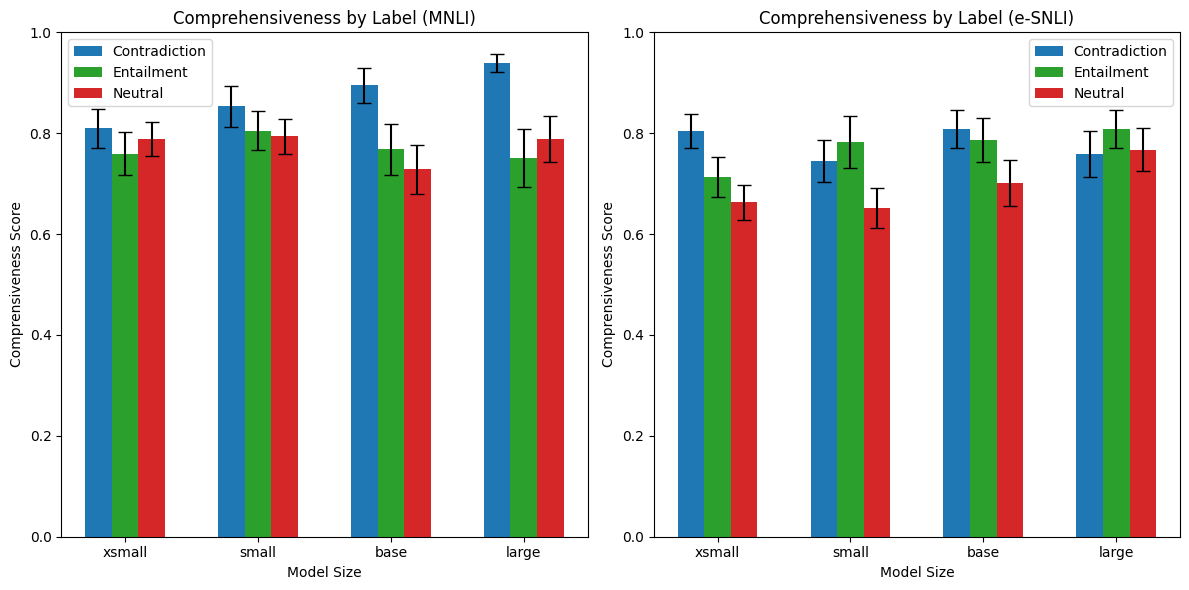

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Function to get SEM
def get_sem(data_list):
    return np.std(data_list) / np.sqrt(len(data_list))

model_names = ['xsmall', 'small', 'base', 'large']
labels = ['contradiction', 'entailment', 'neutral']
dataset_names = ['MNLI', 'e-SNLI']
colors = ['tab:blue', 'tab:green', 'tab:red']
bar_width = 0.2

plt.figure(figsize=(12, 6))

for i, dataset in enumerate(['mnli', 'esnli']):
    plt.subplot(1, 2, i + 1)
    
    for j, label in enumerate(labels):
        means_comp = []
        sems_comp = []
        
        for model_name in model_names:
            comp_key = f'comp_{label}'
            
            mean_comp = np.mean(explainability_results[dataset][model_name]['faithfulness'][comp_key])
            sem_comp = get_sem(explainability_results[dataset][model_name]['faithfulness'][comp_key])
            
            means_comp.append(mean_comp)
            sems_comp.append(sem_comp)

        # Calculate bar positions
        bar_positions = np.arange(len(model_names)) - bar_width + j * bar_width
        
        # Create bar plot
        plt.bar(bar_positions, means_comp, bar_width, color=colors[j], label=f'{label.capitalize()}')
        plt.errorbar(bar_positions, means_comp, yerr=sems_comp, fmt='none', ecolor='black', capsize=5)

    plt.ylim(0, 1)
    plt.xlabel('Model Size')
    plt.ylabel('Comprensiveness Score')
    plt.title(f'Comprehensiveness by Label ({dataset_names[i]})')
    plt.xticks(ticks=np.arange(len(model_names)), labels=model_names)  # Set x-tick labels to model names
    
    plt.legend()

plt.tight_layout()
plt.show()


# Faithfulness by Prediction

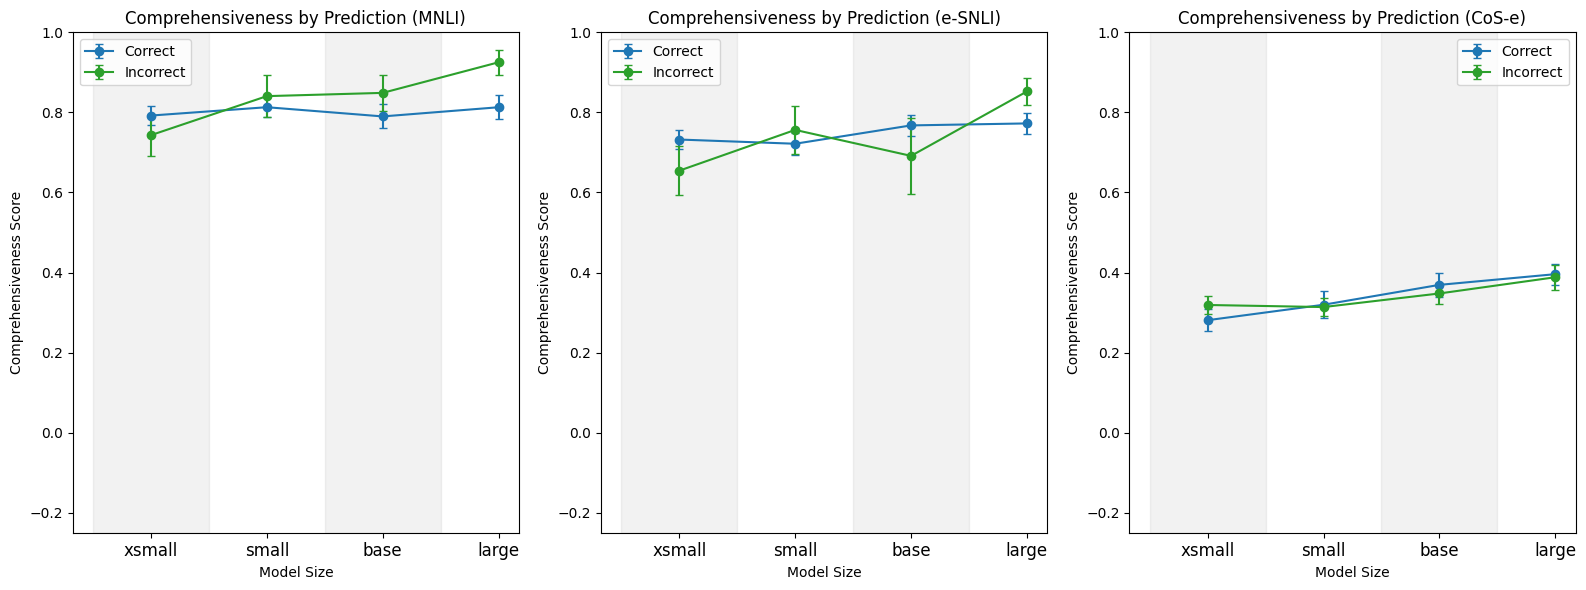

In [89]:
import numpy as np
import matplotlib.pyplot as plt

model_names = ['xsmall', 'small', 'base', 'large']
dataset_names = ['MNLI', 'e-SNLI', 'CoS-e']

plt.figure(figsize=(16, 6))

for i, dataset in enumerate(['mnli', 'esnli', 'cose']):
    plt.subplot(1, 3, i+1)
    
    mean_comp_correct = []
    mean_comp_incorrect = []
    
    sem_comp_correct = []
    sem_comp_incorrect = []
    
    for model_name in model_names:
        comp = np.array(explainability_results[dataset][model_name]['faithfulness']['comprehensiveness'])
        correct_idx = np.array(explainability_results[dataset][model_name]['correct_idx'])
        
        comp_correct = comp[correct_idx]
        comp_incorrect = comp[~correct_idx]
        
        mean_comp_correct.append(np.mean(comp_correct))
        mean_comp_incorrect.append(np.mean(comp_incorrect))
        
        sem_comp_correct.append(get_sem(comp_correct))
        sem_comp_incorrect.append(get_sem(comp_incorrect))

    x_coords = np.arange(len(model_names))
    
    # Add shadowed background for model size
    for j, model in enumerate(model_names):
        if j % 2 == 0:
            plt.axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)
    
    plt.errorbar(x_coords, mean_comp_correct, yerr=sem_comp_correct, linestyle='-', marker='o', color='tab:blue', label='Correct', capsize=3)
    plt.errorbar(x_coords, mean_comp_incorrect, yerr=sem_comp_incorrect, linestyle='-', marker='o', color='tab:green', label='Incorrect', capsize=3)
    
    plt.ylim(-0.25,1)
    plt.xlabel('Model Size')
    plt.ylabel('Comprehensiveness Score')
    plt.title(f'Comprehensiveness by Prediction ({dataset_names[i]})')
    plt.xticks(ticks=x_coords, labels=model_names, fontsize=12)  # Set x-tick labels to model names
    
    plt.legend()

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


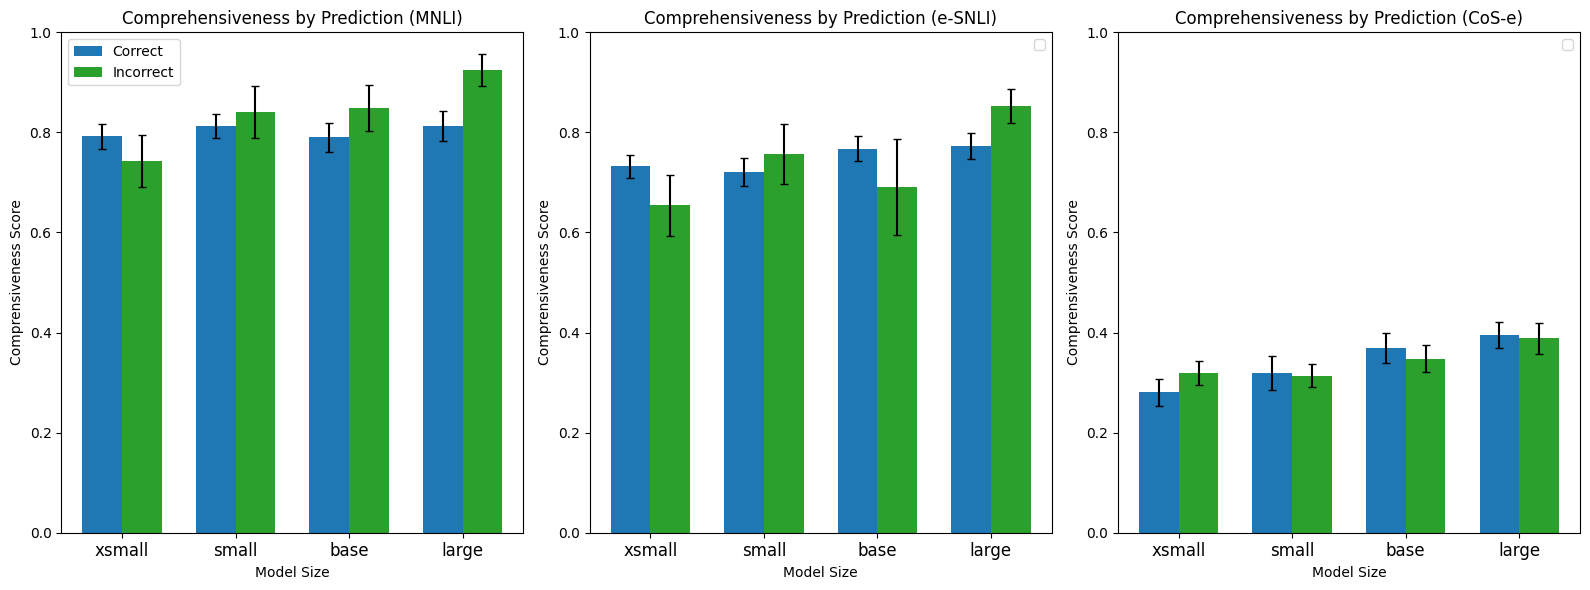

In [90]:
import numpy as np
import matplotlib.pyplot as plt

model_names = ['xsmall', 'small', 'base', 'large']
dataset_names = ['MNLI', 'e-SNLI', 'CoS-e']

plt.figure(figsize=(16, 6))

bar_width = 0.35  # Width of the bars
dodge_amount = bar_width / 2  # Offset for the bars

for i, dataset in enumerate(['mnli', 'esnli', 'cose']):
    plt.subplot(1, 3, i+1)
    
    mean_comp_correct = []
    mean_comp_incorrect = []
    
    sem_comp_correct = []
    sem_comp_incorrect = []
    
    for model_name in model_names:
        comp = np.array(explainability_results[dataset][model_name]['faithfulness']['comprehensiveness'])
        correct_idx = np.array(explainability_results[dataset][model_name]['correct_idx'])
        
        comp_correct = comp[correct_idx]
        comp_incorrect = comp[~correct_idx]
        
        mean_comp_correct.append(np.mean(comp_correct))
        mean_comp_incorrect.append(np.mean(comp_incorrect))
        
        sem_comp_correct.append(get_sem(comp_correct))
        sem_comp_incorrect.append(get_sem(comp_incorrect))

    x_coords = np.arange(len(model_names))
    
    for j in range(len(model_names)):
        plt.bar(x_coords[j] - dodge_amount, mean_comp_correct[j], bar_width, color='tab:blue', yerr=sem_comp_correct[j], capsize=3, label='Correct' if i == 0 and j == 0 else "")
        plt.bar(x_coords[j] + dodge_amount, mean_comp_incorrect[j], bar_width, color='tab:green', yerr=sem_comp_incorrect[j], capsize=3, label='Incorrect' if i == 0 and j == 0 else "")
    
    plt.ylim(0, 1)
    plt.xlabel('Model Size')
    plt.ylabel('Comprensiveness Score')
    plt.title(f'Comprehensiveness by Prediction ({dataset_names[i]})')
    plt.xticks(ticks=x_coords, labels=model_names, fontsize=12)  # Set x-tick labels to model names
    
    plt.legend()

plt.tight_layout()
plt.show()


# Plausibility by Prediction

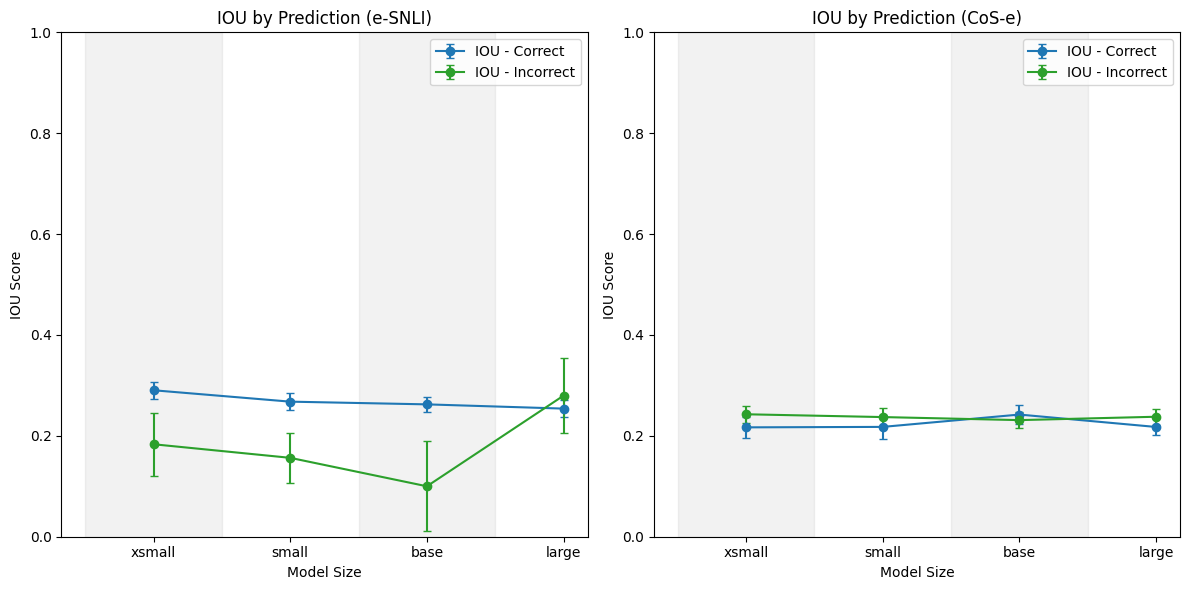

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def get_sem(data_list):
    # Function to get SEM
    return np.std(data_list) / np.sqrt(len(data_list))

model_names = ['xsmall', 'small', 'base', 'large']
dataset_names = ['e-SNLI', 'CoS-e']
line_styles = ['-', '--', ':']

plt.figure(figsize=(12, 6))

for i, dataset in enumerate(['esnli', 'cose']):
    plt.subplot(1, 2, i+1)
    
    mean_iou_correct = []
    mean_iou_incorrect = []
    
    sem_iou_correct = []
    sem_iou_incorrect = []
    
    for model_name in model_names:
        iou = np.array(explainability_results[dataset][model_name]['plausibility']['iou'])
        correct_idx = np.array(explainability_results[dataset][model_name]['correct_idx'])
        
        iou_correct = iou[correct_idx]
        iou_incorrect = iou[~correct_idx]

        mean_iou_correct.append(np.mean(iou_correct))
        mean_iou_incorrect.append(np.mean(iou_incorrect))

        sem_iou_correct.append(get_sem(iou_correct))
        sem_iou_incorrect.append(get_sem(iou_incorrect))
 
    x_coords = np.arange(len(model_names))

    # Add shadowed background for model size
    for j, model in enumerate(model_names):
        if j % 2 == 0:
            plt.axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)
    
    plt.errorbar(x_coords, mean_iou_correct, yerr=sem_iou_correct, linestyle='-', marker='o', color='tab:blue', label='IOU - Correct', capsize=3)
    plt.errorbar(x_coords, mean_iou_incorrect, yerr=sem_iou_incorrect, linestyle='-', marker='o', color='tab:green', label='IOU - Incorrect', capsize=3)

    plt.ylim(0,1)
    plt.xlabel('Model Size')
    plt.ylabel('IOU Score')
    plt.title(f'IOU by Prediction ({dataset_names[i]})')
    plt.xticks(ticks=x_coords, labels=model_names)  # Set x-tick labels to model names
    
    plt.legend()

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


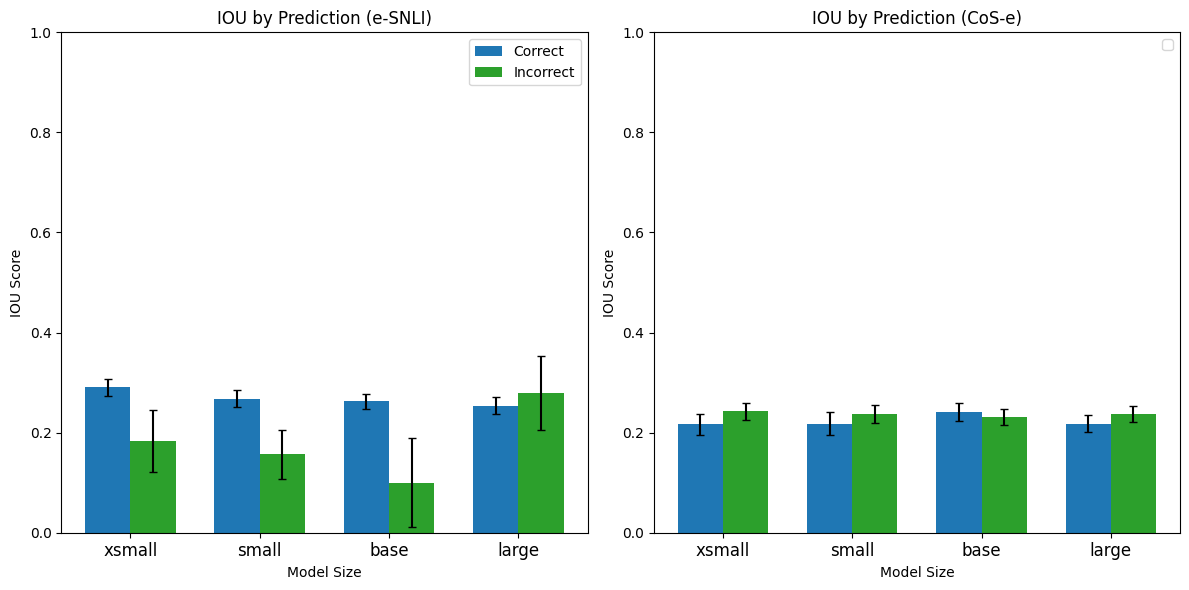

In [92]:
import numpy as np
import matplotlib.pyplot as plt

model_names = ['xsmall', 'small', 'base', 'large']
dataset_names = ['e-SNLI', 'CoS-e']

plt.figure(figsize=(12, 6))

bar_width = 0.35  # Width of the bars
dodge_amount = bar_width / 2  # Offset for the bars

for i, dataset in enumerate(['esnli', 'cose']):
    plt.subplot(1, 2, i+1)
    
    mean_iou_correct = []
    mean_iou_incorrect = []
    
    sem_iou_correct = []
    sem_iou_incorrect = []
    
    for model_name in model_names:
        iou = np.array(explainability_results[dataset][model_name]['plausibility']['iou'])
        correct_idx = np.array(explainability_results[dataset][model_name]['correct_idx'])
        
        iou_correct = iou[correct_idx]
        iou_incorrect = iou[~correct_idx]
        
        mean_iou_correct.append(np.mean(iou_correct))
        mean_iou_incorrect.append(np.mean(iou_incorrect))
        
        sem_iou_correct.append(get_sem(iou_correct))
        sem_iou_incorrect.append(get_sem(iou_incorrect))

    x_coords = np.arange(len(model_names))
    
    for j in range(len(model_names)):
        plt.bar(x_coords[j] - dodge_amount, mean_iou_correct[j], bar_width, color='tab:blue', yerr=sem_iou_correct[j], capsize=3, label='Correct' if i == 0 and j == 0 else "")
        plt.bar(x_coords[j] + dodge_amount, mean_iou_incorrect[j], bar_width, color='tab:green', yerr=sem_iou_incorrect[j], capsize=3, label='Incorrect' if i == 0 and j == 0 else "")
    
    plt.ylim(0, 1)
    plt.xlabel('Model Size')
    plt.ylabel('IOU Score')
    plt.title(f'IOU by Prediction ({dataset_names[i]})')
    plt.xticks(ticks=x_coords, labels=model_names, fontsize=12)  # Set x-tick labels to model names
    
    plt.legend()

plt.tight_layout()
plt.show()


# Plausiblity by Label

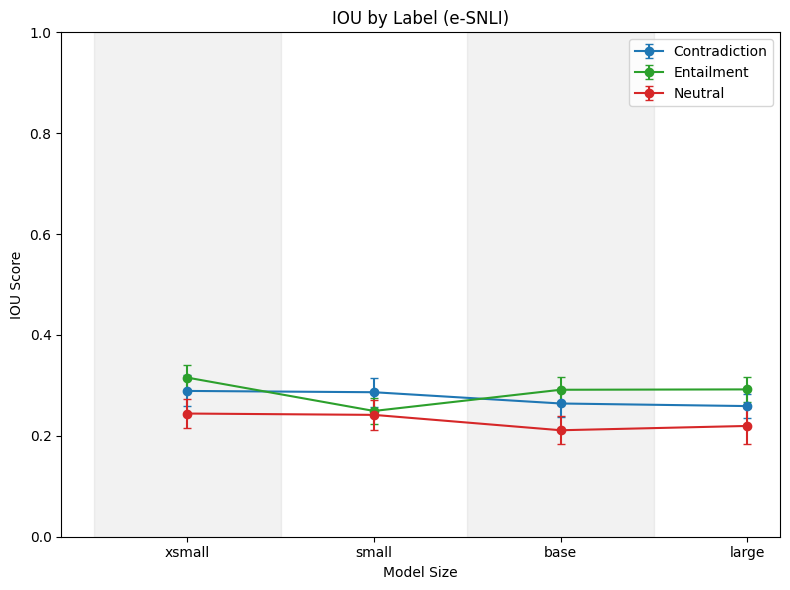

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Function to get SEM
def get_sem(data_list):
    return np.std(data_list) / np.sqrt(len(data_list))

model_names = ['xsmall', 'small', 'base', 'large']
labels = ['Contradiction', 'Entailment', 'Neutral']

plt.figure(figsize=(8, 6))

# Focusing only on e-SNLI dataset
dataset = 'esnli'
plt.title(f'IOU by Label (e-SNLI)')

metric = 'IOU'
colors = ['tab:blue', 'tab:green', 'tab:red']
linestyles = ['-', '--', ':']

dodge_amount = 0.05  # Adjust this value to change the amount of dodging

for label_idx, label in enumerate(labels):
    means = []
    sems = []
    for model_name in model_names:
        data = np.array(explainability_results[dataset][model_name]['plausibility'][metric.lower()])
        label_indices = np.array(explainability_results[dataset]['indices'][f'{label.lower()}_idx'])
        
        means.append(np.mean(data[label_indices]))
        sems.append(get_sem(data[label_indices]))
    
    # Dodge the x-coordinates
    x_coords = np.arange(len(model_names))
    plt.errorbar(x_coords, means, yerr=sems, linestyle='-', marker='o', color=colors[label_idx], label=f'{label}', capsize=3)

# Add shadowed background for model size
for j, model in enumerate(model_names):
    if j % 2 == 0:
        plt.axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)

plt.ylim(0,1)
plt.xlabel('Model Size')
plt.ylabel('IOU Score')
plt.xticks(ticks=np.arange(len(model_names)), labels=model_names)  # Set x-tick labels to model names
plt.legend()

plt.tight_layout()
plt.show()


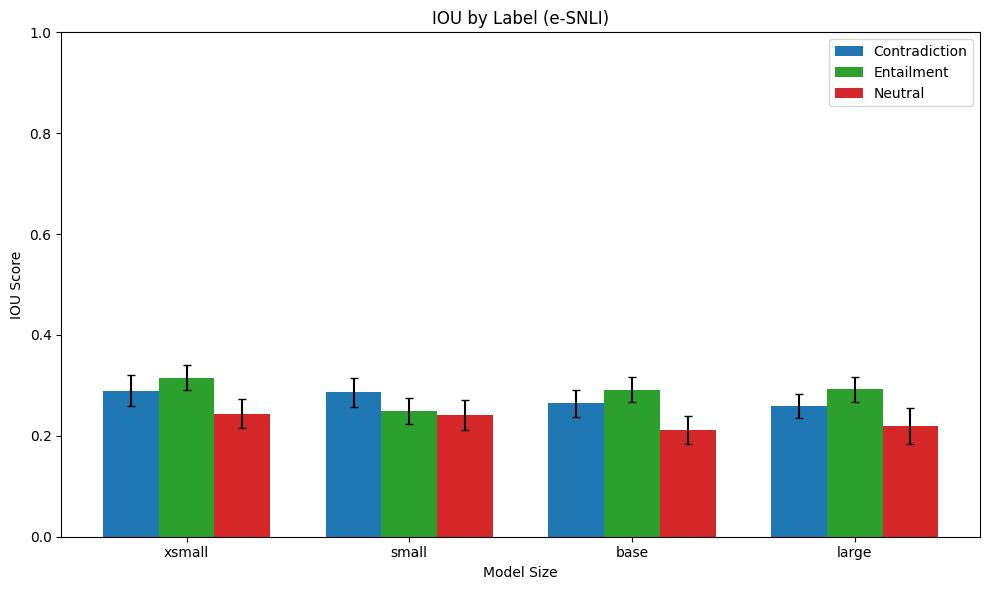

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Function to get SEM
def get_sem(data_list):
    return np.std(data_list) / np.sqrt(len(data_list))

model_names = ['xsmall', 'small', 'base', 'large']
labels = ['Contradiction', 'Entailment', 'Neutral']

plt.figure(figsize=(10, 6))

# Focusing only on e-SNLI dataset
dataset = 'esnli'
plt.title(f'IOU by Label (e-SNLI)')

metric = 'IOU'
colors = ['tab:blue', 'tab:green', 'tab:red']

bar_width = 0.25  # Width of the bars
dodge_amount = bar_width  # Offset for the bars

for label_idx, label in enumerate(labels):
    means = []
    sems = []
    for model_name in model_names:
        data = np.array(explainability_results[dataset][model_name]['plausibility'][metric.lower()])
        label_indices = np.array(explainability_results[dataset]['indices'][f'{label.lower()}_idx'])
        
        means.append(np.mean(data[label_indices]))
        sems.append(get_sem(data[label_indices]))
    
    # Dodge the x-coordinates
    x_coords = np.arange(len(model_names)) + label_idx * dodge_amount - dodge_amount
    plt.bar(x_coords, means, bar_width, color=colors[label_idx], yerr=sems, capsize=3, label=f'{label}')

plt.ylim(0,1)
plt.xlabel('Model Size')
plt.ylabel('IOU Score')
plt.xticks(ticks=np.arange(len(model_names)), labels=model_names)
plt.legend()

plt.tight_layout()
plt.show()
